# Reliability of Probability Estimates

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from mclearn.active import run_active_learning_expt
from mclearn.heuristics import (random_h, margin_h, entropy_h,
                                qbb_margin_h, qbb_kl_h, pool_entropy_h, pool_variance_h)
from mclearn.tools import results_exist, load_results
from mclearn.preprocessing import balanced_train_test_split
from mclearn.viz import plot_learning_curve_df, plot_final_accuracy, order_learning_curves
%matplotlib inline
sns.set_style('ticks')
sns.set_palette('Dark2', 8)

In [7]:
fig_dir = '../thesis/figures/appendix/'
target_col = 'class'
vstatlas_features = ['rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']
sdss_features = ['psfMag_r_w14', 'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14',
                'psf_i_z_w14', 'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14',
                'petro_r_i_w14', 'petro_i_z_w14', 'petroRad_r']

heuristics = [random_h]
xrange = np.arange(50, 301)
labels = ['One-vs-Rest Logistic', 'RBF SVM', 'Multinomial Logistic', 'Forest']
colors = {'One-vs-Rest Logistic': '#e6ab02',
          'Multinomial Logistic': '#66a61e',
          'Forest': '#7570b3',
          'RBF SVM': '#e7298a' }
linestyles = {'One-vs-Rest Logistic': '-',
              'Multinomial Logistic': '-',
              'Forest': '-',
              'RBF SVM': '-'}

sdss_m_path = ['../pickle/appendix/sdss_balanced_multinomial.pickle']
sdss_f_path = ['../pickle/appendix/sdss_balanced_forest.pickle']
sdss_o_path = ['../pickle/06_active_learning/sdss_balanced_logistic_random.pickle']
sdss_r_path = ['../pickle/06_active_learning/sdss_balanced_rbf_random.pickle']
vstatlas_m_path = ['../pickle/appendix/vstatlas_balanced_multinomial.pickle']
vstatlas_f_path = ['../pickle/appendix/vstatlas_balanced_forest.pickle']
vstatlas_o_path = ['../pickle/06_active_learning/vstatlas_balanced_logistic_random.pickle']
vstatlas_r_path = ['../pickle/06_active_learning/vstatlas_balanced_rbf_random.pickle']

## SDSS

In [ ]:
sdss = pd.read_hdf('../data/sdss.h5', 'sdss')
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
X = np.array(sdss[sdss_features])
X_poly = transformer.fit_transform(X)
y = np.array(sdss[target_col])
X_pool, _, y_pool, _ = balanced_train_test_split(X_poly, y, train_size=900000, test_size=0, random_state=11)
kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=10000, train_size=10000, random_state=19)

logistic = LogisticRegression(multi_class='multinomial', penalty='l2', C=0.1, random_state=2, solver='lbfgs', class_weight='auto')
forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='subsample', random_state=2)

In [ ]:
if not results_exist(sdss_m_path):
    run_active_learning_expt(X_pool, y_pool, kfold, logistic, None, heuristics, sdss_m_path)
if not results_exist(sdss_f_path):
    run_active_learning_expt(X_pool, y_pool, kfold, forest, None, heuristics, sdss_f_path)

## VST ATLAS

In [ ]:
vstatlas = pd.read_hdf('../data/vstatlas.h5', 'vstatlas')
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
X = np.array(vstatlas[vstatlas_features])
X_poly = transformer.fit_transform(X)
y = np.array(vstatlas[target_col])
X_pool, _, y_pool, _ = balanced_train_test_split(X_poly, y, train_size=2360, test_size=0, random_state=11)
kfold = StratifiedShuffleSplit(y_pool, n_iter=10, test_size=0.3, train_size=0.7, random_state=19)

logistic = LogisticRegression(multi_class='multinomial', penalty='l2', C=1000000, random_state=2, solver='lbfgs', class_weight='auto')
forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='subsample', random_state=2)

In [ ]:
if not results_exist(vstatlas_m_path):
    run_active_learning_expt(X_pool, y_pool, kfold, logistic, None, heuristics, vstatlas_m_path)
if not results_exist(vstatlas_f_path):
    run_active_learning_expt(X_pool, y_pool, kfold, forest, None, heuristics, vstatlas_f_path)

## Comparison

In [4]:
sdss_m = load_results(sdss_m_path)[0][0]
sdss_f = load_results(sdss_f_path)[0][0]
sdss_o = load_results(sdss_o_path)[0][0]
sdss_r = load_results(sdss_r_path)[0][0]
vstatlas_m = load_results(vstatlas_m_path)[0][0]
vstatlas_f = load_results(vstatlas_f_path)[0][0]
vstatlas_o = load_results(vstatlas_o_path)[0][0]
vstatlas_r = load_results(vstatlas_r_path)[0][0]

sdss_df = order_learning_curves([sdss_o, sdss_r, sdss_m, sdss_f], labels)
vstatlas_df = order_learning_curves([vstatlas_o, vstatlas_r, vstatlas_m, vstatlas_f], labels)

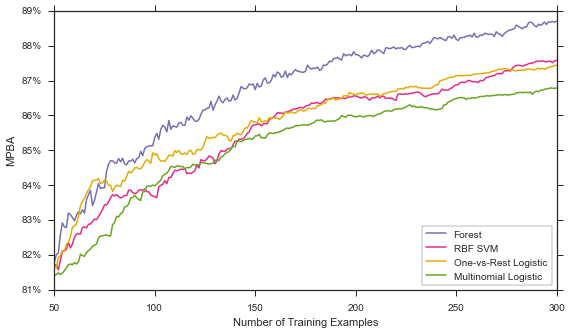

In [8]:
fig = plt.figure(figsize=(9, 5))
ax = plot_learning_curve_df(xrange, sdss_df, sdss_df.columns, colors, linestyles)
fig.savefig(fig_dir+'sdss_forest_multinom.pdf', bbox_inches='tight')

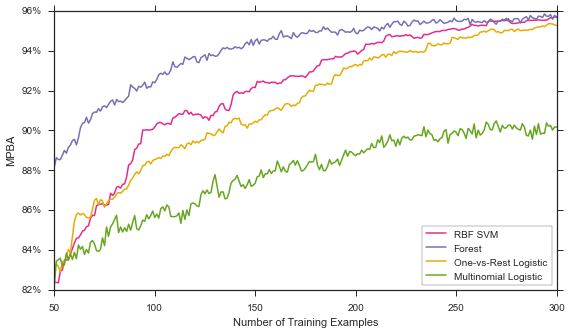

In [10]:
fig = plt.figure(figsize=(9, 5))
ax = plot_learning_curve_df(xrange, vstatlas_df, vstatlas_df.columns, colors, linestyles)
fig.savefig(fig_dir+'vstatlas_forest_multinom.pdf', bbox_inches='tight')